# Titanik, stablo odlučivanja i "matrica konfuzije"

Kako stablo odlučivanja može da pomogne u proceni šansi za preživljavanje? Koji su nam parametri važni i pouzdani? Koliko nam parametara treba da napravimo dobru predikciju? Kako da odredimo tačnost i preziznost modela?

Primer "Titanik" koji koristimo je tipičan za mašinsko učenje. Podatke o putnicima sa Titanika je lako naći na netu. Preuzmite te podatke kao csv fajl i postavite u radni direktorijum.

In [1]:
titanic <- read.csv("titanic.csv", header = TRUE, sep = ",")

Da vidimo zaglavlje tabele i imena kolona.

In [2]:
head(titanic)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,,135,"Montreal, PQ / Chesterville, ON"
5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"
6,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NA,"New York, NY"


Znam da ovde na kraju postoji putnik za kog nema podataka. Da to ne biste otkrivali "hard way" pogledajte `tail` tabele. Ovog bi putnika valjalo izostaviti iz analize.

In [3]:
tail(titanic)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>
1305,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,,C,,328,
1306,3,0,"Zabour, Miss. Thamine",female,NA,1,0,2665,14.4542,,C,,NA,
1307,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,,C,,304,
1308,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,,C,,NA,
1309,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,,S,,NA,
1310,NA,NA,,,NA,NA,NA,,NA,,,,NA,


In [4]:
# u R-u [-1310,] znači da izbacujemo 1310. red tabele
titanic <- titanic[-1310,]

Za prikaz rezultata ćemo koristiti biblioteku `ggplot2`. Ona ima malo lepši prikaz.

In [5]:
library(ggplot2)

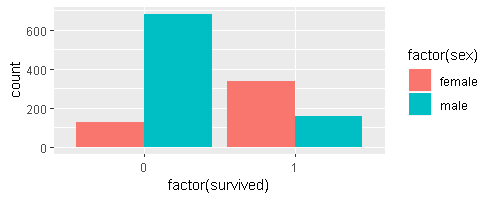

In [6]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 100)
ggplot(titanic,aes(x=factor(survived),fill=factor(sex)))+
  geom_bar(position="dodge")


Sad isto to, ali prema tome da li su preživeli ili ne.

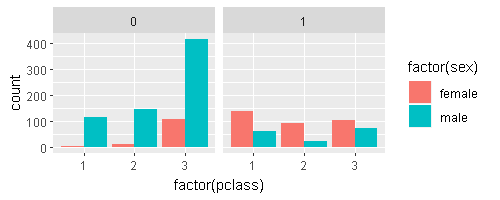

In [7]:
ggplot(titanic,aes(x=factor(pclass),fill=factor(sex)))+
  geom_bar(position="dodge")+
  facet_grid(". ~ survived")

Dodaćemo kolonu `child` u tabelu jer je to verovatno dobar prediktor. Svi koji imaju manje od 18 godina imaće flag 1 u toj koloni.

In [8]:
# dete
titanic$child = 0
titanic$child[titanic$age < 18] = 1

# tabela preživljavanja
table(child=titanic$child,survived=titanic$survived)

     survived
child   0   1
    0 736 419
    1  73  81

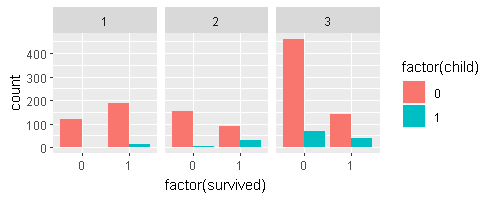

In [9]:
ggplot(titanic,aes(x=factor(survived),fill=factor(child)))+
  geom_bar(position="dodge")+
  facet_grid(". ~ pclass")

E, sad da pustimo mašinu da uči. 

Prvo uzimamo uzorak za učenje. Otprilike 75% cele tabele. Taj deo ćemo zvati `train`. Ostatak ćemo uzeti za testiranje i zvaćemo ga  `test`.

In [10]:
# slučajnih 1000 redova
uzorak=sample(1:1309, 1000)

In [11]:
train=titanic[uzorak,]

In [12]:
test=titanic[-uzorak,]

In [13]:
head(train)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,child
,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1125,3,0,"Peters, Miss. Katie",female,NA,0,0,330935,8.1375,,Q,,NA,,0
396,2,1,"Doling, Miss. Elsie",female,18,0,1,231919,23.0000,,S,,NA,Southampton,0
405,2,0,"Enander, Mr. Ingvar",male,21,0,0,236854,13.0000,,S,,NA,"Goteborg, Sweden / Rockford, IL",0
366,2,0,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44,1,0,244252,26.0000,,S,,NA,London,0
1103,3,0,"Panula, Master. Juha Niilo",male,7,4,1,3101295,39.6875,,S,,NA,,1
1150,3,1,"Riordan, Miss. Johanna ""Hannah""",female,NA,0,0,334915,7.7208,,Q,13,NA,,0


### Stablo odlučivanja

Ovaj algoritam bira najbolja pitanja (zasnovana na podacima u tabeli) kojima mogućnosti deli tako da informativnost bude najveća. Na taj način ćemo sa nekoliko pitanja dobiti najpouzdaniju moguću predikciju.

Za to ćemo koristiti biblioteku `rpart`.

In [14]:
# ako treba, instalirajte prvo biblioteku sa install.packages('rpart')
library(rpart)

### Učenje

In [15]:
# mašina uči na osnovu svih podataka čiji su nazivi dati posle ~
#drvo <- rpart(survived ~ pclass + sex + age + sibsp + parch + fare + embarked, data = train, method = "class")
drvo <- rpart(survived ~ pclass + sex + child, data = train, method = "class")

Sad crtamo drvo uz pomoć funkcije `plot`. Ovo će verovatno izgledati katastrofalno.

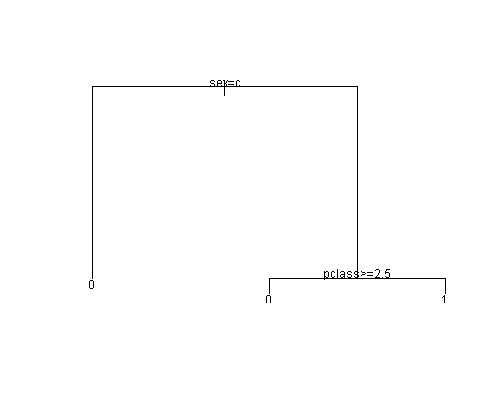

In [16]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 100)
plot(drvo)
text(drvo,cex = .7)

Srećom, postoje biblioteke koje bolje crtaju ova stabla.

In [17]:
#install.packages('rattle')

library(rattle)
library(rpart.plot)
library(RColorBrewer)

Warning message:
"package 'rattle' was built under R version 3.6.3"Rattle: A free graphical interface for data science with R.
Version 5.3.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Warning message:
"package 'rpart.plot' was built under R version 3.6.3"

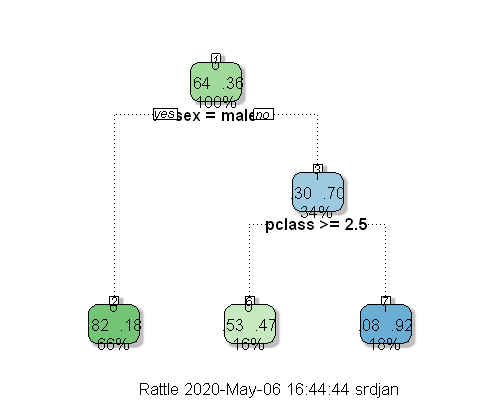

In [18]:
# "fancy" varijanta
fancyRpartPlot(drvo)

### Predikcije

Sad da vidimo koliko su dobre predikcije za ovo stablo.

In [19]:
# uvek koristimo test za testiranje!
predikcije <- predict(drvo, test, type = "class")

redni_broj = as.numeric(row.names(test))
izlaz <- data.frame(redni_broj, predikcija = predikcije, preziveo=titanic$survived[redni_broj])

Računamo koliko ima True Positiv (TP), False Negative (FN), False Positive (FP) i True Negative (TN) predikcija.

In [20]:
TP=sum(izlaz$predikcija==1 & izlaz$preziveo==1)
FN=sum(izlaz$predikcija==0 & izlaz$preziveo==1)
FP=sum(izlaz$predikcija==1 & izlaz$preziveo==0)
TN=sum(izlaz$predikcija==0 & izlaz$preziveo==0)

Na osnovu tih podataka računamo tačnost, preciznost, osetljivost i specifičnost predikcije.

In [21]:
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision=TP/(TP+FP)
sensitivity=TP/(TP+FN)
specificity=TN/(TN+FP)

In [22]:
accuracy

[1] 0.7605178

In [23]:
precision

[1] 0.9589041

In [24]:
sensitivity

[1] 0.4964539

In [25]:
specificity

[1] 0.9821429

Sad ove podatke možemo da smestimo u "confusion matrix".

In [26]:
cm=data.frame(survived=c(TP,FN),drowned=c(FP,TN),row.names = c("positive","negative"))

In [27]:
cm

,survived,drowned
,<int>,<int>
positive,70,3
negative,71,165


Probajte drvo odlučivanja sa različitim prediktorima. Možda ne moramo da ih uzmemo sve. Kako sad izgleda matrica konfuzije?